In [57]:
# import warnings
# from pathlib import Path

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# data_dir = Path('../data')
# figure_dir = Path('../figures')
# figure_dir.mkdir(exist_ok=True)
# warnings.simplefilter(action='ignore', category=FutureWarning)

# district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
# district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
# institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

# districts_in_city = [
#     'Valli',
#     'Salakkalahti',
#     'Repola',
#     'Anina',
#     'Papula',
#     'P_Annan_kruunu',
#     'Hiekka',
#     'Pantsarlahti',
#     'Viipurin_esikaupunki',
#     'Paulovski',
#     'Havi',
#     'Saunalahti',
#     'Pietarin_esikaupunki',
# ]

# poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
# poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
# poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
# poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
# remove = poll_tax.in_russia_orthodox.copy()
# remove.loc['1906':] = 0
# poll_tax['orthodox'] = poll_tax.orthodox - remove
# health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
# health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
# foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
# language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
# religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
# difference = health_council - poll_tax.orthodox
# data = pd.DataFrame([
#     difference,
#     poll_tax.orthodox,
#     poll_tax.in_russia_orthodox,
#     poll_tax.total,
#     health_council,
#     foreigners,
#     language,
#     religion,
# ]).T
# data.columns = [
#     'difference',
#     'register_orthodox',
#     'orthodox_in_russia',
#     'register_total',
#     'health_council_orthodox',
#     'Russian_citizens',
#     'Russian_speakers',
#     'census_orthodox',
# ]
# data.interpolate(method='linear', inplace=True)
# data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 25_000))
# plt.savefig(figure_dir / 'timeseries1.png')
# data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 4_000))
# plt.savefig(figure_dir / 'timeseries2.png')

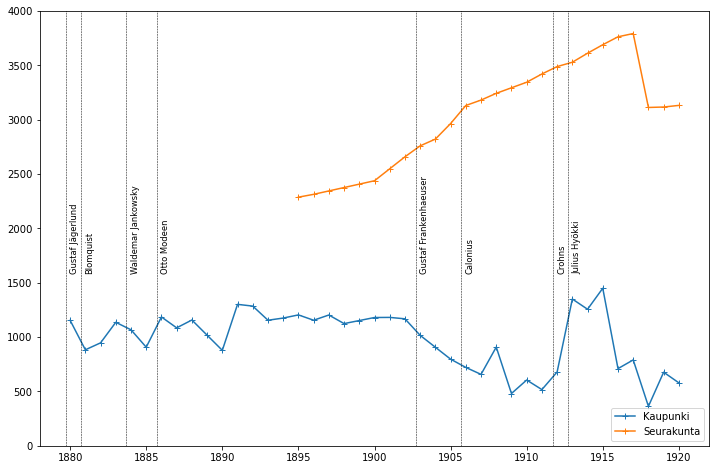

In [58]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path('../data')
figure_dir = Path('../figures')
figure_dir.mkdir(exist_ok=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

clerks = {
    'Gustaf Jägerlund': 1880,
    'Blomquist': 1881,
    'Waldemar Jankowsky': 1884,
    'Otto Modeen': 1886,
    'Gustaf Frankenhaeuser': 1903,
    'Calonius': 1906,
    'Crohns': 1912,
    'Julius Hyökki': 1913,
}

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
# remove = poll_tax.in_russia_orthodox.copy()
# remove.loc['1895':] = 0
# remove.loc['1912':] = 0
# poll_tax['orthodox'] = poll_tax.orthodox - remove
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
clerk = pd.Series({v: k for k, v in clerks.items()}, name='clerk')
data = pd.DataFrame([
    poll_tax.orthodox,
    health_council,
    clerk,
]).T
data = data.ffill()
starts = data.clerk.map(clerks)
data.columns = [
    'Kaupunki',
    'Seurakunta',
    'Henkikirjoittaja',
]
data.plot(
    marker='+',
    legend=True,
    ylim=(0, 4_000),
    figsize=(12, 8),
)
for c, y in clerks.items():
    plt.axvline(y-0.3, ymin=0, ymax=4000, color='black', ls='--', lw=0.5)
    plt.text(x=y, y=1600, s=c, rotation='vertical', fontsize='small')
plt.legend()
plt.savefig(figure_dir / 'timeseries.png')

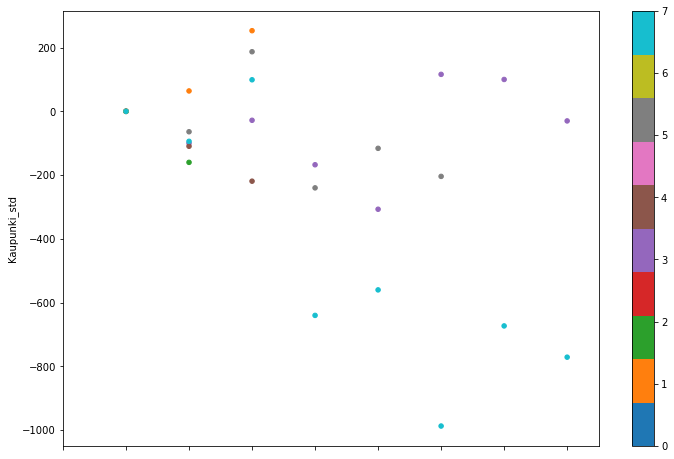

In [59]:
experience_data = data.copy()
start_level = data.Kaupunki[data.index.isin(list(clerks.values()))]
experience_data['start_level'] = start_level
experience_data = experience_data.interpolate(method='ffill')
experience_data['Kaupunki_std'] = experience_data.Kaupunki - experience_data.start_level
mapper = {v: k for k, v in enumerate(clerks)}
colors = data.Henkikirjoittaja.map(mapper)
experience = data.index.values - starts + 1
experience_data['experience'] = experience
experience_data.plot(
    kind='scatter',
    x='experience',
    y='Kaupunki_std',
    c=colors,
    cmap=plt.get_cmap('tab10'),
    figsize=(12, 8),
    xlim=(0, 8.5),
)
data.drop(columns=['Henkikirjoittaja'], inplace=True)

[1893. 1905. 1917.]


Text(0, 0.5, 'basis')

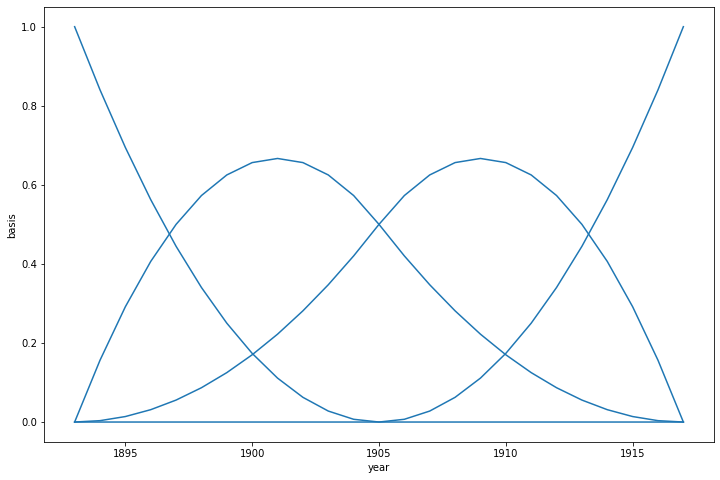

In [60]:
import arviz as az
import pymc3 as pm
from patsy import dmatrix

regression_data = data.loc['1893':'1917', 'Kaupunki']
regression_data.loc['1903':'1912'] = np.nan
regression_data.loc['1916':'1917'] = np.nan

n_knots = 3
knot_list = np.linspace(regression_data.index[0], regression_data.index[-1], n_knots)
print(knot_list)
B = dmatrix(
    "bs(year, knots=knots, degree=2, include_intercept=True) - 1",
    {"year": regression_data.index.values, "knots": knot_list[1:-1]},
)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
for i in range(n_knots + 1):
    ax.plot(regression_data.index, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis")

C:\Users\antth\Anaconda3\envs\pymc3\lib\site-packages\pymc3\model.py:1755: ImputationWarning: Data in orthodox contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [orthodox_missing, sigma, w, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7107585826721594, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\antth\Anaconda3\envs\pymc3\lib\site-packages\arviz\plots\plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (43) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'w\n0'}>,
        <AxesSubplot:title={'center':'w\n1'}>,
        <AxesSubplot:title={'center':'w\n2'}>],
       [<AxesSubplot:title={'center':'w\n3'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n0'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n1'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n2'}>],
       [<AxesSubplot:title={'center':'orthodox_missing\n3'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n4'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n5'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n6'}>],
       [<AxesSubplot:title={'center':'orthodox_missing\n7'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n8'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n9'}>,
        <AxesSubplot:title={'center':'orthodox_missing\n10'}>],
       [<AxesSubplot:title={'center':'orthodox_missing\n11'}>,
        <AxesSubpl

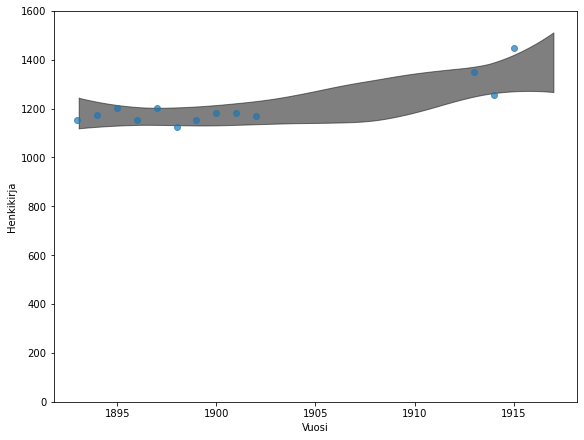

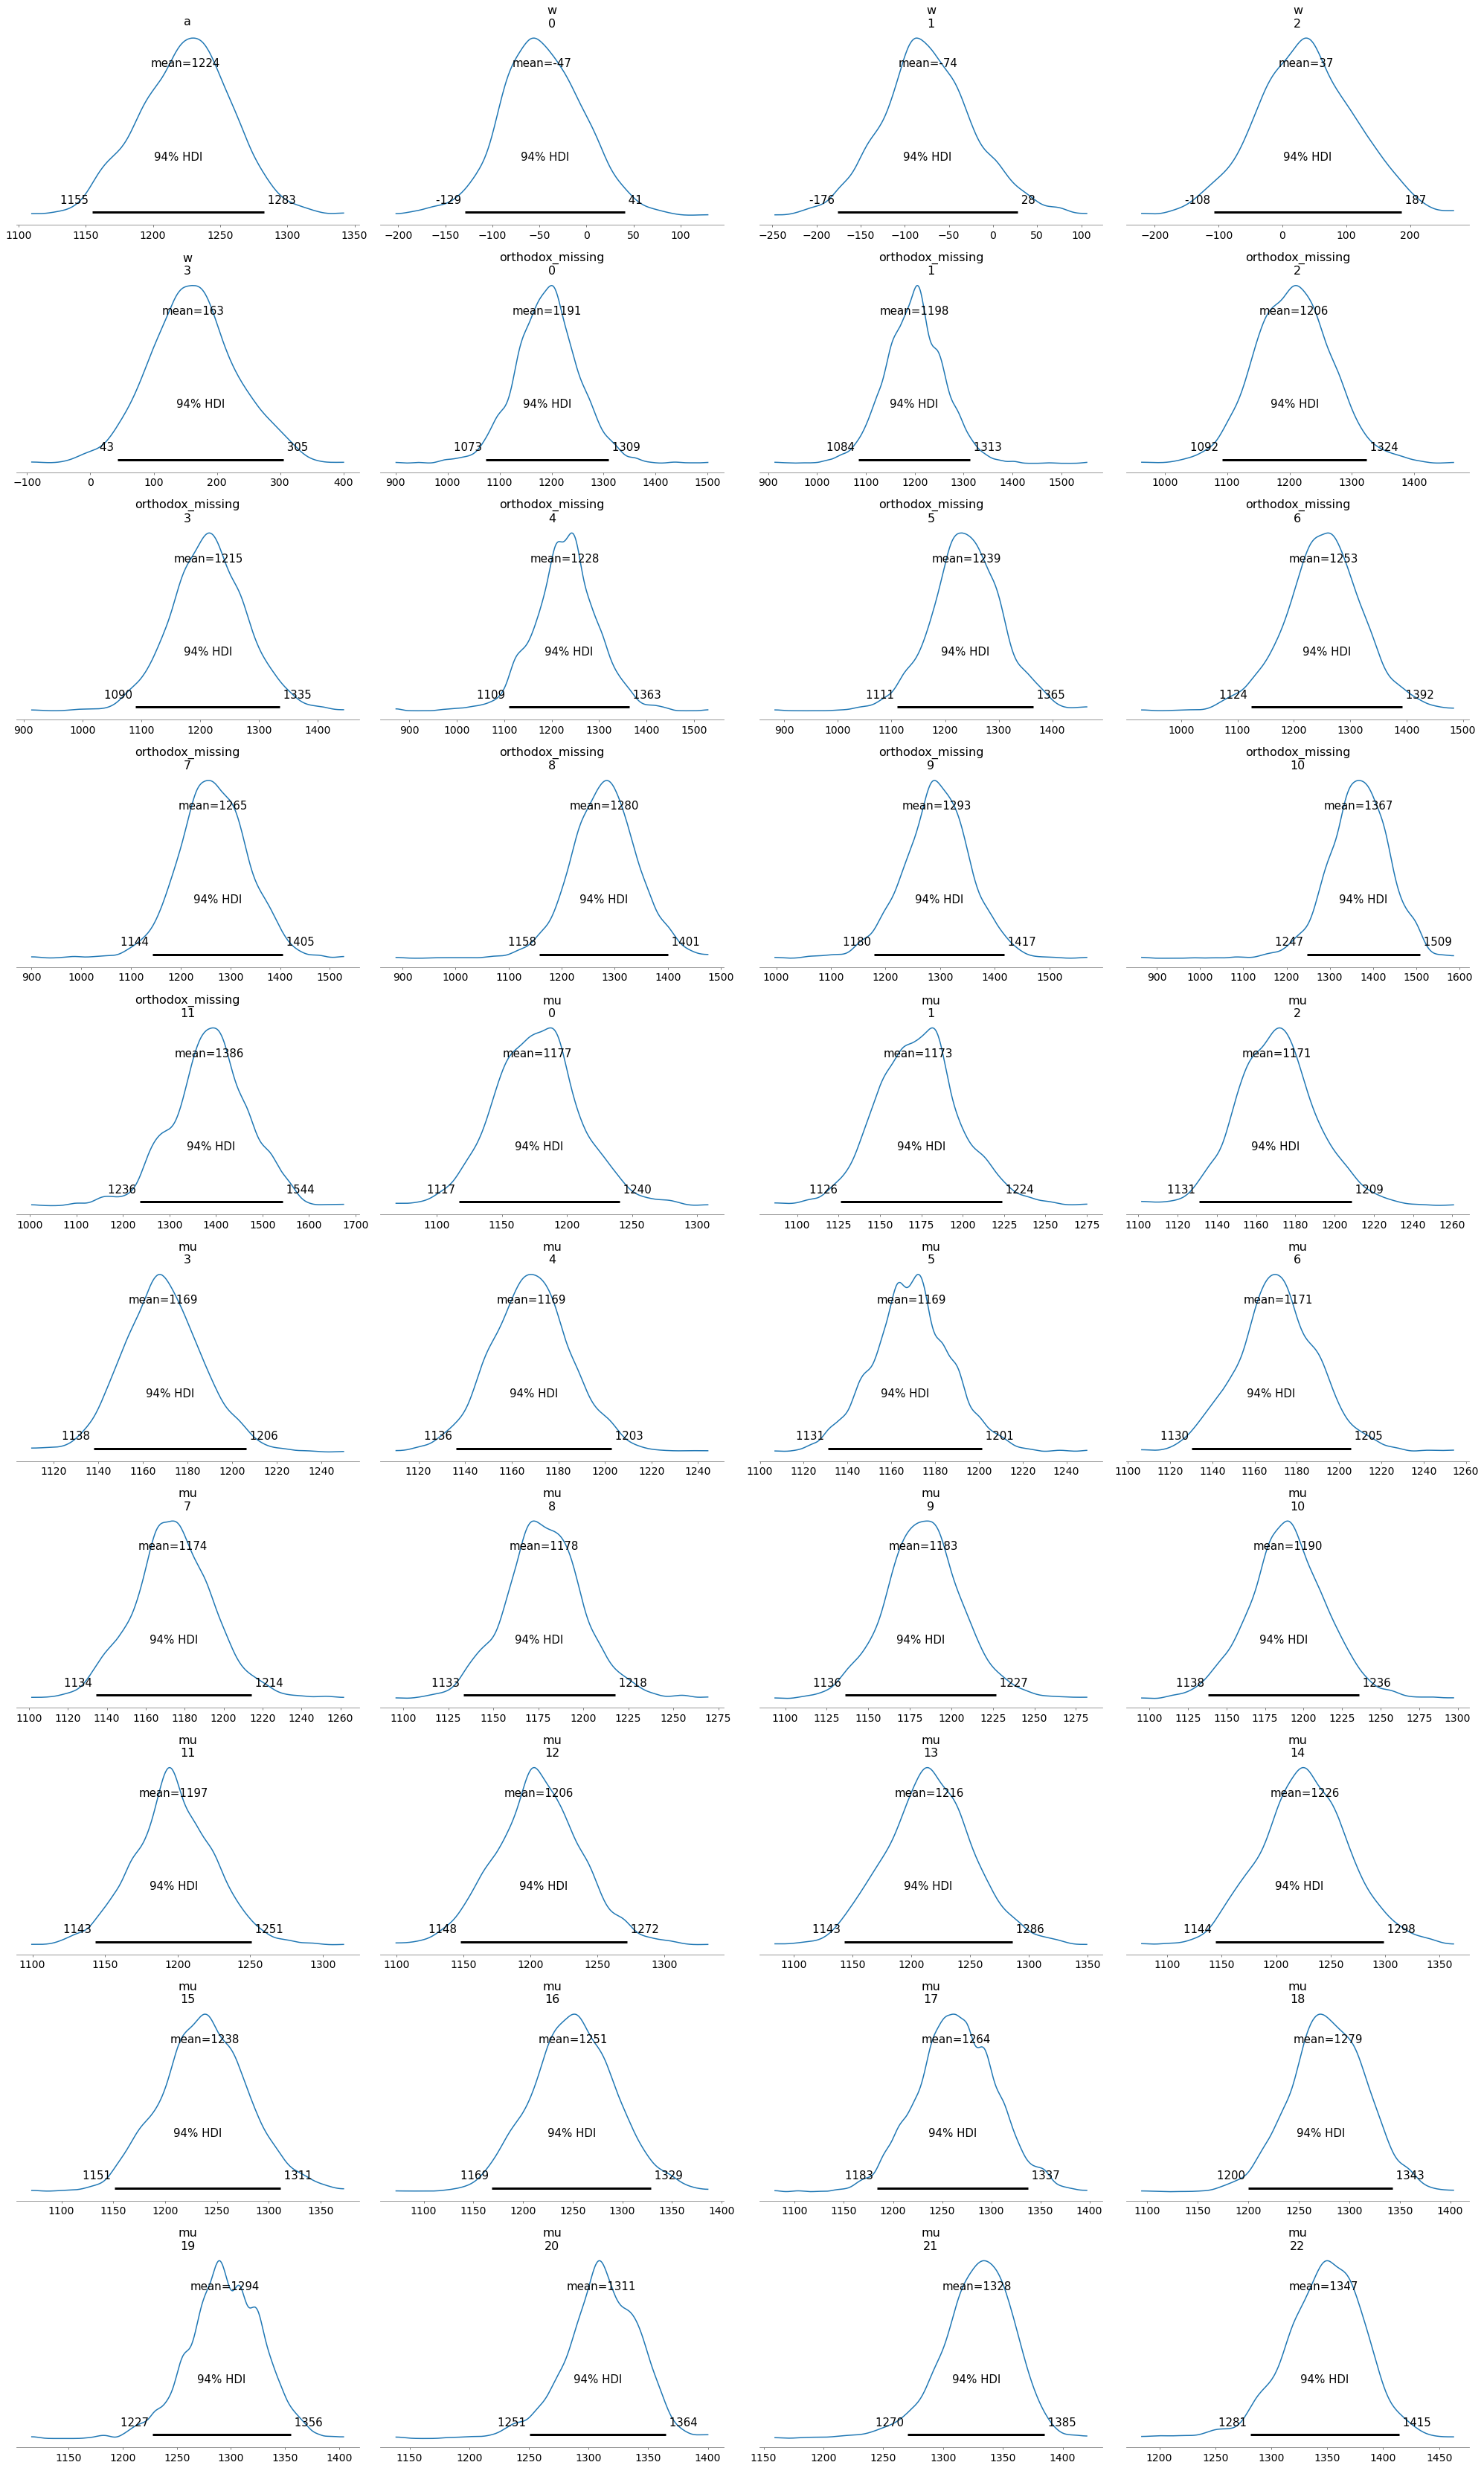

In [63]:
with pm.Model() as model:
    a = pm.Normal("a", 1200, 50)
    w = pm.Normal("w", mu=0, sd=100, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.HalfNormal("sigma", sd=100)
    orthodox = pm.Normal("orthodox", mu, sigma, observed=regression_data)
    posterior = pm.sample(1000)

ax = az.plot_hdi(regression_data.index, posterior["mu"], color="k", hdi_prob=0.95)
ax.plot(regression_data.index, regression_data, "o", alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(8, 6)
ax.set_ylim(0, 1600)
ax.set_xlabel("Vuosi")
ax.set_ylabel("Henkikirja")

az.plot_posterior(posterior)